In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import torch.nn as nn
from vae_model import VAE, REDNetVAE
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../lib")))
from utils import get_split_datapaths, psnr, init_logging, assess_model
from dataloader import PassiveMicrowaveDataset
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import cv2
from torchvision.transforms import ToTensor

from datetime import datetime

logger = init_logging()

In [3]:
train_paths, val_paths, test_paths = get_split_datapaths()

2025-05-23 10:28:14,561 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/11 does not exist. Skipping...
2025-05-23 10:28:14,561 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/11 does not exist. Skipping...
2025-05-23 10:28:14,563 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/12 does not exist. Skipping...
2025-05-23 10:28:14,563 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/12 does not exist. Skipping...
2025-05-23 10:28:14,563 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/01 does not exist. Skipping...
2025-05-23 10:28:14,563 - root - INFO - Warning: Directory /lustre/storeB/p

In [4]:
# Initialize test dataset with normalization
test_dataset = PassiveMicrowaveDataset(test_paths, transform=ToTensor(), normalize=True, use_bicubic=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import peak_signal_noise_ratio as scikit_PSNR

def plot_single_sample(model_pth, test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu", mask_land =False, denormalize = True):
    """
    Plot a single test sample's low-resolution input, high-resolution ground truth, 
    and model output along with the PSNR and MSE.
    """
    time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    dt.strftime("%Y-%m-%d %H:00")
    print(dt)
    if "VAE" in model_pth.split("_")[1].split("/"):
        model = VAE()
    if "REDNetVAE" in model_pth.split("_")[1].split("/"):
        model = REDNetVAE()


    model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
    model.eval()  # Set the model to evaluation mode

    # Get a single test sample
    low_res, high_res = test_dataset[sample_idx]

    # Convert to batch format and move to device
    low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
    high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)

    # Run model inference
    with torch.no_grad():
        output = model(low_res_tensor)[0]

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output = output.squeeze(0).cpu().numpy()

    filtered_low_res_v = low_res[0][low_res[0] > 0]
    filtered_high_res_v = high_res[0][high_res[0] > 0]
    combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
    v_min = np.min(combined_filtered_v)
    v_max = np.max(combined_filtered_v)

    filtered_low_res_h = low_res[1][low_res[1] > 0]
    filtered_high_res_h = high_res[1][high_res[1] > 0]
    combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
    h_min = np.min(combined_filtered_h)
    h_max = np.max(combined_filtered_h)

    if mask_land:
        output[0][output[0] < v_min] = 0
        output[1][output[1] < h_min] = 0

    psnr_value_v = psnr(torch.tensor(output[0]), torch.tensor(high_res[0]), pol="V").item()
    # scikit_psnr_v = scikit_PSNR(output[0], high_res[0], data_range=pol_max_val['V'])
    psnr_baseline_v = psnr(torch.tensor(low_res[0]), torch.tensor(high_res[0]), pol="V").item()
    # scikit_psnr_baenline_v = scikit_PSNR(high_res[0], low_res[0], data_range=pol_max_val['V'])
    psnr_value_h = psnr(torch.tensor(output[1]), torch.tensor(high_res[1]), pol="H").item()
    psnr_baseline_h = psnr(torch.tensor(low_res[1]), torch.tensor(high_res[1]), pol="H").item()

    # SSIM
    ssim_low_res_v = ssim(high_res[0], low_res[0], data_range=low_res[0].max() - low_res[0].min())
    ssim_low_res_h = ssim(high_res[1], low_res[1], data_range=low_res[1].max() - low_res[1].min())
    ssim_output_v = ssim(high_res[0], output[0], data_range=output[0].max() - output[0].min())
    ssim_output_h = ssim(high_res[1], output[1], data_range=output[1].max() - output[1].min())

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    
    # V-pol comparison
    im1 = axs[0, 0].imshow(low_res[0], cmap='turbo', vmin=v_min, vmax=v_max)
    axs[0, 0].axis('off')
    axs[0, 0].set_title("Low-Res SSMI 37 GHz (Input)")
    axs[0, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_v:.3f}\nSSIM: {ssim_low_res_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 0].transAxes)

    im2 = axs[0, 1].imshow(high_res[0], cmap='turbo', vmin=v_min, vmax=v_max)  # Ground Truth
    axs[0, 1].axis('off')
    axs[0, 1].set_title("High-Res AMSR 37 GHz (Ground Truth)")

    im3 = axs[0, 2].imshow(output[0], cmap='turbo', vmin=v_min, vmax=v_max)  # VAE Output
    axs[0, 2].axis('off')
    axs[0, 2].set_title("VAE Output")
    axs[0, 2].text(0.7, 0.9, f"PSNR: {psnr_value_v:.3f}\nSSIM: {ssim_output_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 2].transAxes)

    # H-pol comparison
    im4 = axs[1, 0].imshow(low_res[1], cmap='turbo', vmin=h_min, vmax=h_max)
    axs[1, 0].axis('off')
    axs[1, 0].set_title("")
    axs[1, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_h:.3f}\nSSIM: {ssim_low_res_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 0].transAxes)

    im5 = axs[1, 1].imshow(high_res[1], cmap='turbo', vmin=h_min, vmax=h_max)  # Ground Truth
    axs[1, 1].axis('off')
    axs[1, 1].set_title("")

    im6 = axs[1, 2].imshow(output[1], cmap='turbo', vmin=h_min, vmax=h_max)  # VAE Output
    axs[1, 2].axis('off')
    axs[1, 2].set_title("")
    axs[1, 2].text(0.7, 0.9, f"PSNR: {psnr_value_h:.3f}\nSSIM: {ssim_output_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 2].transAxes)

    axs[0, 0].annotate("V-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    axs[1, 0].annotate("H-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)

    # Add colorbars outside the plot
    cbar_ax1 = fig.add_axes([0.9, 0.46, 0.02, 0.415])  # Top row
    cbar_ax2 = fig.add_axes([0.9, 0.025, 0.02, 0.415])  # Bottom row
    fig.colorbar(im2, cax=cbar_ax1, label='Brightness Temperature (K)')
    fig.colorbar(im5, cax=cbar_ax2, label='Brightness Temperature (K)')
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, .9, .92])
    # plt.show()

2020-02-16 12:00:00


/tmp/ipykernel_2022845/1253303019.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-05-19 13:32:39,516 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f954bf53200>
2025-05-19 13:32:39,516 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f954bf53200>
2025-05-19 13:32:39,520 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f954a2e0590>
2025-05-19 13:32:39,520 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f954a2e0590>


/tmp/ipykernel_2022845/1253303019.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


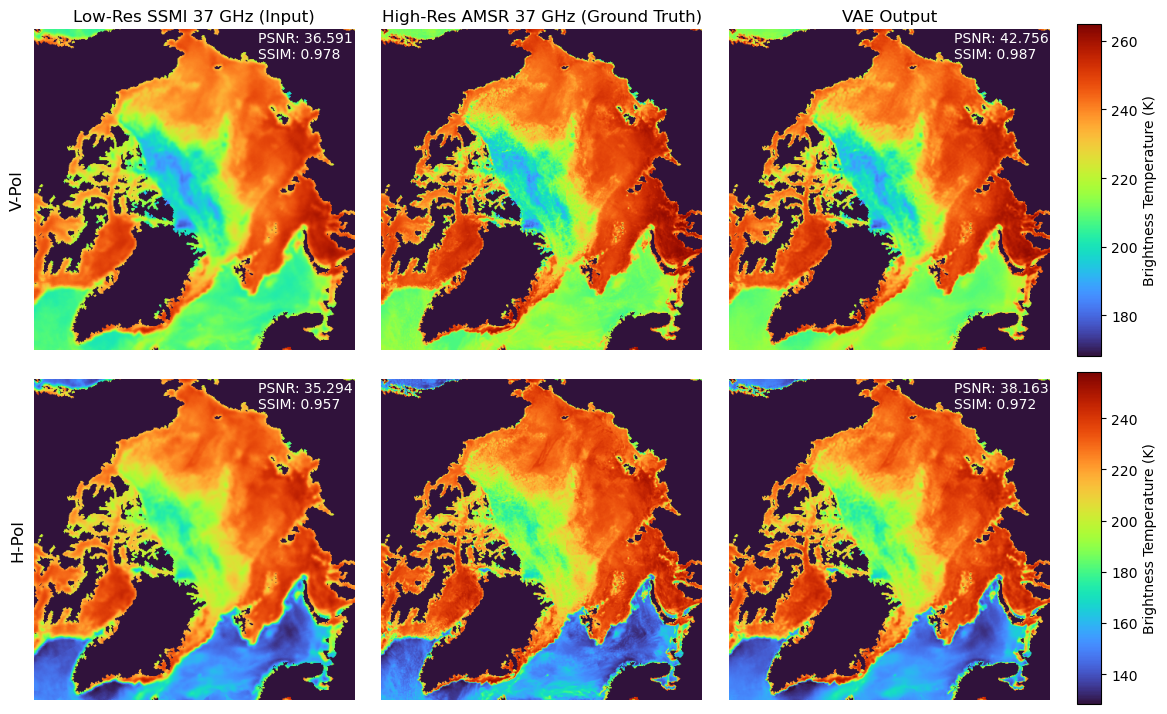

In [18]:
model_pth = "trained_models/REDNetVAE_24h_batch8_samplesall.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=40,
                   mask_land=True);

2020-02-16 12:00:00


/tmp/ipykernel_3363394/1253303019.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-05-15 14:15:24,125 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fe9c51e51c0>
2025-05-15 14:15:24,125 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fe9c51e51c0>
2025-05-15 14:15:24,129 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fe9c51e5280>
2025-05-15 14:15:24,129 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fe9c51e5280>


/tmp/ipykernel_3363394/1253303019.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


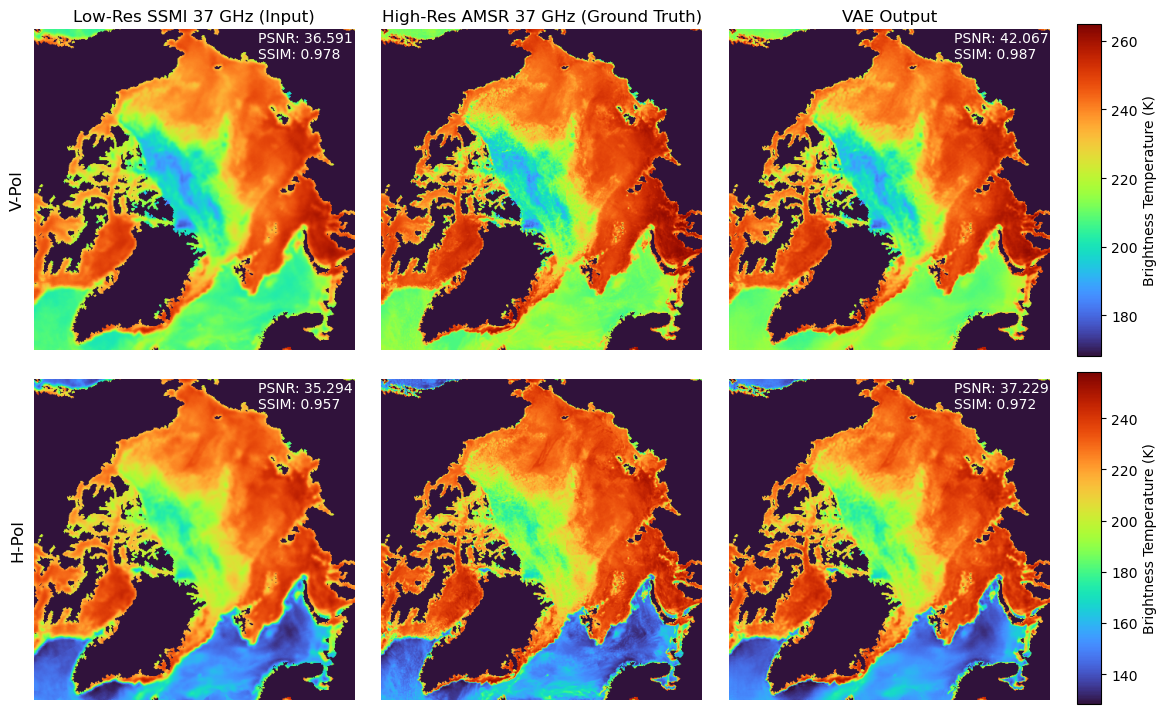

In [35]:
model_pth = "trained_models/REDNetVAE_24h_batch8_samplesall_at_epoch19.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=40,
                   mask_land=True);

# Ensemble variance

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import peak_signal_noise_ratio as scikit_PSNR

def plot_single_sample_ensemble(ens_members, model_pth, test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu", mask_land =False, denormalize = True):
    """
    Plot a single test sample's low-resolution input, high-resolution ground truth, 
    and model output along with the PSNR and MSE.
    """
    time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    dt.strftime("%Y-%m-%d %H:00")
    print(dt)
    if "VAE" in model_pth.split("_")[1].split("/"):
        model = VAE()
    if "REDNetVAE" in model_pth.split("_")[1].split("/"):
        model = REDNetVAE()


    model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
    model.eval()  # Set the model to evaluation mode

    # Get a single test sample
    low_res, high_res = test_dataset[sample_idx]

    # Convert to batch format and move to device
    low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
    high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)

    ens = np.zeros((ens_members, 2, 416, 416))

    for i in range(ens_members):
        # Run model inference
        with torch.no_grad():
            output = model(low_res_tensor)[0]

        # Move data back to CPU and convert to NumPy
        if denormalize:
            low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
            high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
            output = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
        else:
            low_res = low_res_tensor.squeeze(0).cpu().numpy()
            high_res = high_res_tensor.squeeze(0).cpu().numpy()
            output = output.squeeze(0).cpu().numpy()

        filtered_low_res_v = low_res[0][low_res[0] > 0]
        filtered_high_res_v = high_res[0][high_res[0] > 0]
        combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
        v_min = np.min(combined_filtered_v)
        v_max = np.max(combined_filtered_v)

        filtered_low_res_h = low_res[1][low_res[1] > 0]
        filtered_high_res_h = high_res[1][high_res[1] > 0]
        combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
        h_min = np.min(combined_filtered_h)
        h_max = np.max(combined_filtered_h)

        if mask_land:
            output[0][output[0] < v_min] = 0
            output[1][output[1] < h_min] = 0
        ens[i] = output

    # print(len[ens])
    # print(ens[0])
    # print(ens[1])
    variance_map = np.var(ens, axis=0)
    var_max = 0.5 #np.max(variance_map)
    var_min = np.min(variance_map)
    print(variance_map[0])
    print(variance_map[1])



    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    
    # V-pol comparison
    im1 = axs[0, 0].imshow(low_res[0], cmap='turbo', vmin=v_min, vmax=v_max)
    axs[0, 0].axis('off')
    axs[0, 0].set_title("Low-Res SSMI 37 GHz (Input)")

    im2 = axs[0, 1].imshow(high_res[0], cmap='turbo', vmin=v_min, vmax=v_max)  # Ground Truth
    axs[0, 1].axis('off')
    axs[0, 1].set_title("High-Res AMSR 37 GHz (Ground Truth)")

    im3 = axs[0, 2].imshow(variance_map[0], cmap='turbo', vmin=0.0, vmax=0.2)  # VAE variance_map
    axs[0, 2].axis('off')
    axs[0, 2].set_title(f"VAE Variance over {ens_members} generations")

    # H-pol comparison
    im4 = axs[1, 0].imshow(low_res[1], cmap='turbo', vmin=h_min, vmax=h_max)
    axs[1, 0].axis('off')
    axs[1, 0].set_title("")

    im5 = axs[1, 1].imshow(high_res[1], cmap='turbo', vmin=h_min, vmax=h_max)  # Ground Truth
    axs[1, 1].axis('off')
    axs[1, 1].set_title("")

    im6 = axs[1, 2].imshow(variance_map[1], cmap='turbo', vmin=0.0, vmax=0.2)  # VAE variance_map
    axs[1, 2].axis('off')
    axs[1, 2].set_title("")

    axs[0, 0].annotate("V-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    axs[1, 0].annotate("H-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)

    # Add colorbars outside the plot
    cbar_ax1 = fig.add_axes([0.9, 0.46, 0.02, 0.415])  # Top row
    cbar_ax2 = fig.add_axes([0.9, 0.025, 0.02, 0.415])  # Bottom row
    fig.colorbar(im3, cax=cbar_ax1, label='Variance (K)')
    fig.colorbar(im6, cax=cbar_ax2, label='Variance (K)')
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, .9, .92])

2020-02-16 12:00:00


/tmp/ipykernel_1042845/593716153.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


[[0.         0.         0.         ... 0.02345279 0.03071524 0.00902821]
 [0.01892316 0.         0.         ... 0.         0.         0.02731403]
 [0.01222243 0.02871648 0.         ... 0.         0.         0.        ]
 ...
 [0.01575987 0.00773747 0.00227835 ... 0.         0.         0.        ]
 [0.00447869 0.00453714 0.0029821  ... 0.         0.         0.        ]
 [0.00668579 0.00969581 0.00408447 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.11766207 0.14671119 0.03619982]
 [0.16013379 0.         0.         ... 0.         0.         0.12999572]
 [0.09206019 0.10665504 0.         ... 0.         0.         0.        ]
 ...
 [0.04452408 0.01595003 0.01359145 ... 0.         0.         0.        ]
 [0.02053691 0.02975676 0.01065283 ... 0.         0.         0.        ]
 [0.02159154 0.0370721  0.0208073  ... 0.         0.         0.        ]]
2025-05-20 10:07:15,899 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fe9

/tmp/ipykernel_1042845/593716153.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


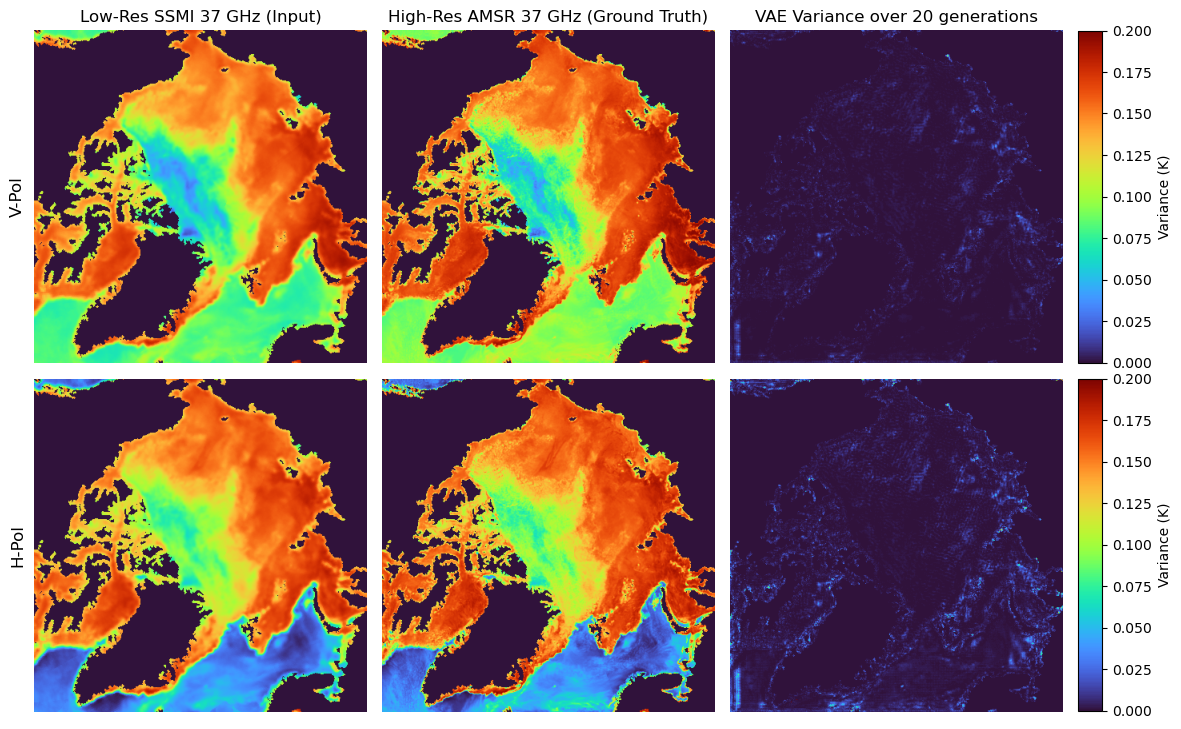

In [9]:
model_pth = "trained_models/REDNetVAE_24h_batch8_samplesall.pth"
plot_single_sample_ensemble(ens_members = 20,
                   model_pth=model_pth,
                   test_paths=test_paths,
                   test_dataset=test_dataset,
                   sample_idx=40,
                   mask_land=True);

In [5]:
ens_members = 20
model_pth = "trained_models/REDNetVAE_24h_batch8_samplesall.pth"
test_paths = test_paths
test_dataset = test_dataset
sample_idx = 40
device="cuda" if torch.cuda.is_available() else "cpu"
mask_land =False
denormalize = True

time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
dt = datetime.strptime(str(time), "%Y%m%d%H")
dt.strftime("%Y-%m-%d %H:00")
print(dt)
if "VAE" in model_pth.split("_")[1].split("/"):
    model = VAE()
if "REDNetVAE" in model_pth.split("_")[1].split("/"):
    model = REDNetVAE()


model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
model.eval()  # Set the model to evaluation mode

# Get a single test sample
low_res, high_res = test_dataset[sample_idx]

# Convert to batch format and move to device
low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)

ens = np.zeros((ens_members, 2, 416, 416))

for i in range(ens_members):
    # Run model inference
    with torch.no_grad():
        output = model(low_res_tensor)[0]

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output = output.squeeze(0).cpu().numpy()

    filtered_low_res_v = low_res[0][low_res[0] > 0]
    filtered_high_res_v = high_res[0][high_res[0] > 0]
    combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
    v_min = np.min(combined_filtered_v)
    v_max = np.max(combined_filtered_v)

    filtered_low_res_h = low_res[1][low_res[1] > 0]
    filtered_high_res_h = high_res[1][high_res[1] > 0]
    combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
    h_min = np.min(combined_filtered_h)
    h_max = np.max(combined_filtered_h)

    if mask_land:
        output[0][output[0] < v_min] = 0
        output[1][output[1] < h_min] = 0
    ens[i] = output

# print(len[ens])
# print(ens[0])
# print(ens[1])
variance_map = np.var(ens, axis=0)
var_max = 0.5 #np.max(variance_map)
var_min = np.min(variance_map)
print(variance_map[0])
print(variance_map[1])

2020-02-16 12:00:00


/tmp/ipykernel_331480/73537665.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


[[0.         0.         0.         ... 0.02846903 0.02572167 0.00741912]
 [0.02293219 0.         0.         ... 0.         0.         0.05306832]
 [0.01115537 0.01434921 0.         ... 0.         0.         0.        ]
 ...
 [0.01013811 0.00408904 0.01003453 ... 0.         0.         0.        ]
 [0.01376706 0.01030267 0.03729777 ... 0.         0.         0.        ]
 [0.00206264 0.00149688 0.01073517 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.19114938 0.12252227 0.07756261]
 [0.20603362 0.         0.         ... 0.         0.         0.28984917]
 [0.10627724 0.05052076 0.         ... 0.         0.         0.        ]
 ...
 [0.01612134 0.00819711 0.06969724 ... 0.         0.         0.        ]
 [0.03904114 0.01632278 0.0674104  ... 0.         0.         0.        ]
 [0.00881971 0.004496   0.02675855 ... 0.         0.         0.        ]]


In [6]:
plt.rcParams.update({'font.size': plt.rcParams['font.size'] + 1})

2025-05-23 10:36:53,791 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21ac6267b0>
2025-05-23 10:36:53,791 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21ac6267b0>


/tmp/ipykernel_331480/228538662.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .89, .95])


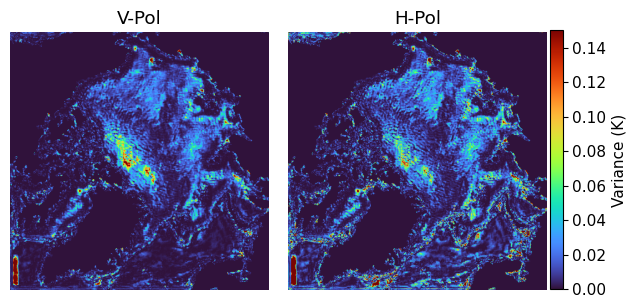

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6.4, 3.2))

# V-pol comparison
im1 = axs[0].imshow(variance_map[0], cmap='turbo', vmin=0, vmax=0.15)
axs[0].axis('off')
axs[0].set_title("V-Pol")

im2 = axs[1].imshow(variance_map[1], cmap='turbo', vmin=0, vmax=0.15)
axs[1].axis('off')
axs[1].set_title("H-Pol")

# Add colorbar
cbar = fig.colorbar(im2, ax=axs, orientation='vertical', fraction=0.04, pad=0.04, shrink= 1.05)
cbar.set_label("Variance (K)")

# Move colorbar down by adjusting its position
cbar_ax = cbar.ax
pos = cbar_ax.get_position()
# Modify the y-position (second value) and height (fourth value) slightly
cbar_ax.set_position([pos.x0, pos.y0 - 0.02, pos.width, pos.height])

plt.tight_layout(rect=[0, 0, .89, .95])
plt.savefig("../final_figures/VAE_variance.pdf", bbox_inches="tight")
